In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def display_images(images):
    _, axes = plt.subplots(2, 2, figsize=(6, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

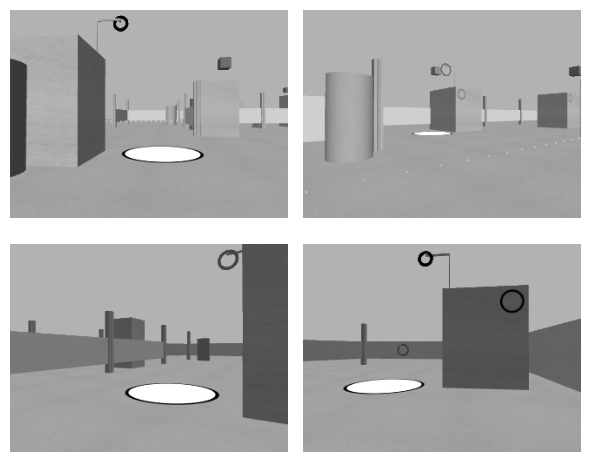

In [3]:
# path = "/home/thelegend442/faxic/RINS-kappa/workspace/src/dis_tutorial5/images/"
path = "workspace/src/dis_tutorial5/images/"
img1 = cv2.imread(path + "gray_screen1.png")
img2 = cv2.imread(path + "gray_screen2.png")
img3 = cv2.imread(path + "gray_screen3.png")
img4 = cv2.imread(path + "gray_screen4.png")

images = [img1, img2, img3, img4]
display_images(images)

Number of ellipses detected: 7


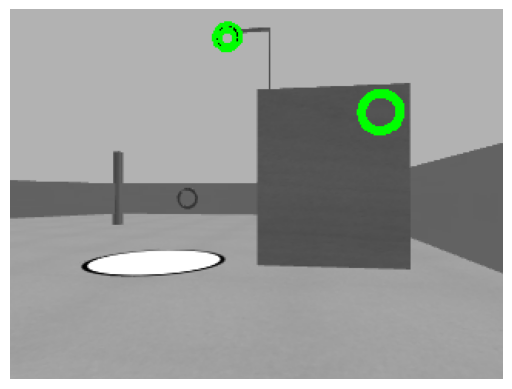

In [25]:
def draw_ellipses2(img, ellipses):
    image = img.copy()
    for ellipse in ellipses:
        cv2.ellipse(image, ellipse, (0, 255, 0), 2)
    
    # colored image

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    # display_images(image)

def ellipse_detection(image, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=50):
    cut_image = image[0:90,0:320]
    image_blured = cv2.GaussianBlur(cut_image, (3, 3), 0)
    
    # edges_images = []
    ellipses = []
        
    edges = cv2.Canny(image_blured, canny_threshold1, canny_threshold2) # Apply Canny edge detection
    # edges_images.append(edges)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    for contour in contours:
        if len(contour) >= 5:  # Fit ellipse requires at least 5 points
            ellipse = cv2.fitEllipse(contour)
            (center, axes, angle) = ellipse
            major_axis = max(axes)
            minor_axis = min(axes)
            if major_axis == 0 or minor_axis == 0:
                continue
            if major_axis/minor_axis > 2:
                continue
            if min_major_axis <= major_axis <= max_major_axis:
                ellipses.append(ellipse)
    
    return ellipses
        
img = images[3]
ellipsis = ellipse_detection(img, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=50)
print(f"Number of ellipses detected: {len(ellipsis)}")
draw_ellipses2(img, ellipsis)

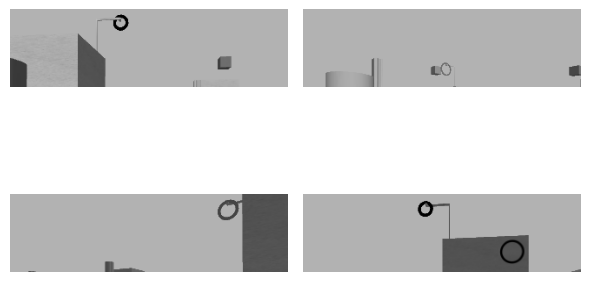

In [5]:
def cut_images(images):
    cut_images = []
    for image in images:
        cut_image = image[0:90,0:320]
        cut_images.append(cut_image)
    return cut_images
cutted_images = cut_images(images)
display_images(cutted_images)

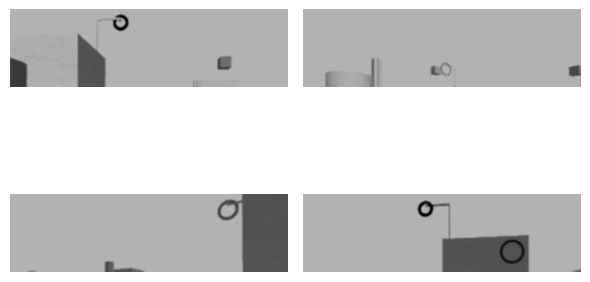

In [6]:

images_blured = []
for image in cutted_images:
    image_blured = cv2.GaussianBlur(image, (3, 3), 0)
    images_blured.append(image_blured)
display_images(images_blured)

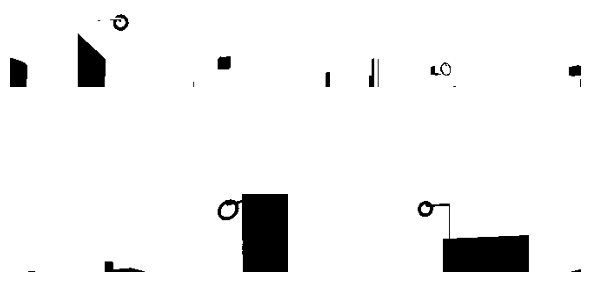

In [7]:
def otsu_thresholding(images, blur_ksize=(7, 7), apply_blur=True):
    thresholded_images = []
    for image in images:
        if apply_blur:
            image = cv2.GaussianBlur(image, blur_ksize, 0)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholded_images.append(thresh)
    return thresholded_images
thresholded_images = otsu_thresholding(cutted_images, blur_ksize=(7, 7), apply_blur=False)
display_images(thresholded_images)

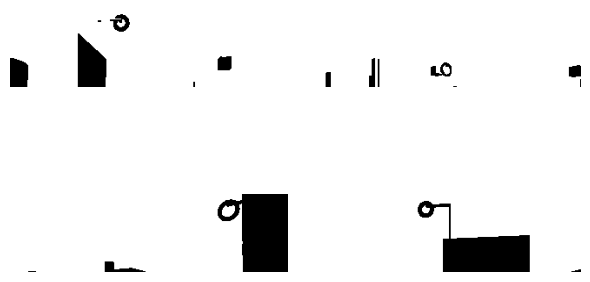

In [8]:
def perform_erosion(images, kernel_size=(3, 3), iterations=1):
    kernel = np.ones(kernel_size, np.uint8)
    eroded_images = []
    for image in images:
        eroded = cv2.erode(image, kernel, iterations=iterations)
        eroded_images.append(eroded)
    return eroded_images

eroded_images = perform_erosion(thresholded_images, kernel_size=(2, 2), iterations=1)
display_images(eroded_images)

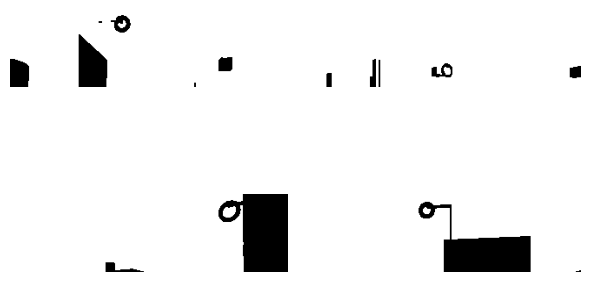

In [9]:
def perform_opening(images, kernel_size=(3, 3), iterations=1):
    kernel = np.ones(kernel_size, np.uint8)
    opened_images = []
    for image in images:
        opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=iterations)
        opened_images.append(opened)
    return opened_images

opened_images = perform_opening(eroded_images, kernel_size=(2, 2), iterations=1)
display_images(opened_images)

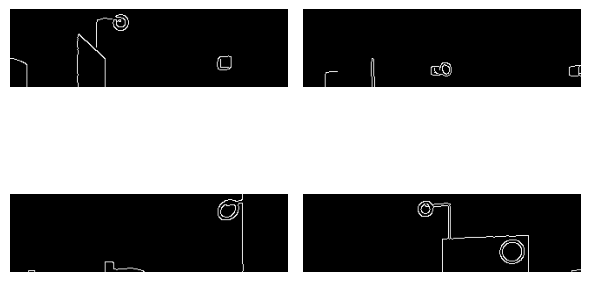

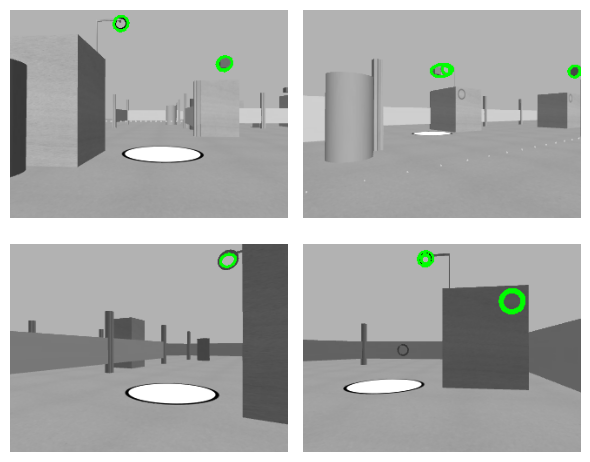

In [10]:
def find_ellipses(images, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=80):
    ellipses_per_img = []
    edges_images = []
    for image in images:
        ellipses = []
        # Apply Canny edge detection
        edges = cv2.Canny(image, canny_threshold1, canny_threshold2)
        edges_images.append(edges)
        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        
        for contour in contours:
            if len(contour) >= 5:  # Fit ellipse requires at least 5 points
                ellipse = cv2.fitEllipse(contour)
                (center, axes, angle) = ellipse
                major_axis = max(axes)
                minor_axis = min(axes)
                if major_axis == 0 or minor_axis == 0:
                    continue
                if major_axis/minor_axis > 2:
                    continue
                if min_major_axis <= major_axis <= max_major_axis:
                    ellipses.append(ellipse)
                

        ellipses_per_img.append(ellipses)

    display_images(edges_images)
    return ellipses_per_img

ellipses_per_image = find_ellipses(images_blured, canny_threshold1=50, canny_threshold2=150, min_major_axis=10, max_major_axis=50)

def draw_ellipses(images, ellipses_per_image):
    images_copy = [img.copy() for img in images]
    for i, img in enumerate(images_copy):
        for ellipse in ellipses_per_image[i]:
            cv2.ellipse(img, ellipse, (0, 255, 0), 2)

    display_images(images_copy)

draw_ellipses(images, ellipses_per_image)

<h2>Color detection</h2>

In [33]:
class Point:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

class Ring():
    def __init__(self, ellipse1, ellipse2, center3D=None, color=None):
        self.ellipse1 = ellipse1
        self.ellipse2 = ellipse2

        self.center1 = Point(0, 0)
        self.center2 = Point(0, 0)

        self.center1.x = int(ellipse1[0][0])
        self.center1.y = int(ellipse1[0][1])

        self.center2.x = int(ellipse2[0][0])
        self.center2.y = int(ellipse2[0][1])

        self.center3D = center3D  # np.array([x, y, z]=

        self.color = color

In [91]:
ring_black = cv2.imread(path + "color_ring1.png")
ring_red = cv2.imread(path + "color_ring2.png")
ring_green = cv2.imread(path + "color_ring3.png")
ring_blue = cv2.imread(path + "color_ring5.png")
rings_color = [ring_black, ring_red, ring_green, ring_blue]

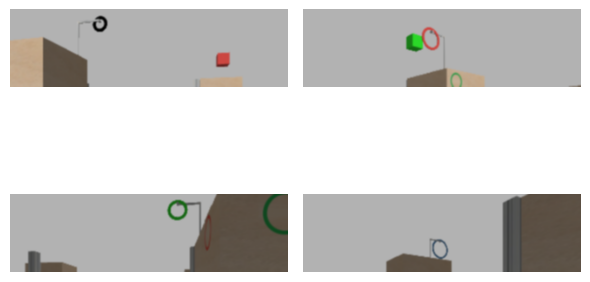

In [92]:
cut_images_color = cut_images(rings_color.copy())
blurred_images_color = []
for image in cut_images_color:
    image_blured = cv2.GaussianBlur(image, (3, 3), 0)
    blurred_images_color.append(image_blured)
display_images(blurred_images_color)

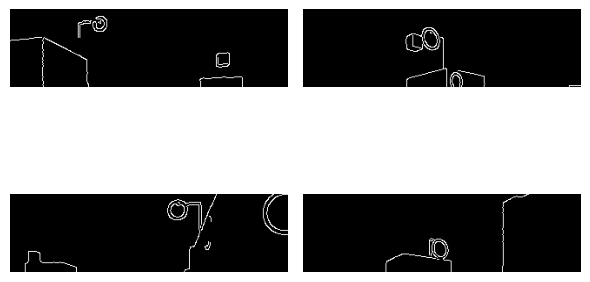

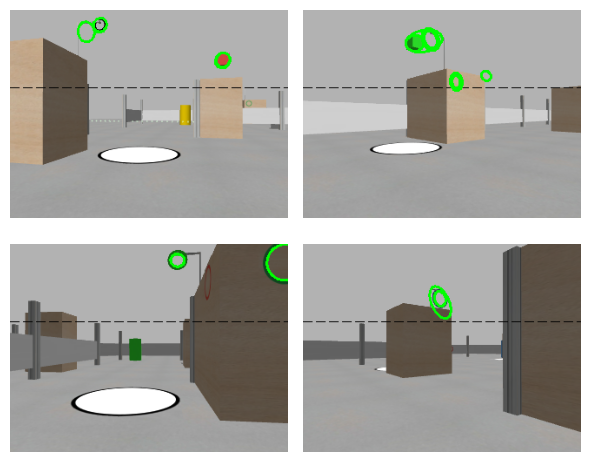

In [93]:
ellipses_per_image_color = find_ellipses(blurred_images_color, canny_threshold1=70, canny_threshold2=150, min_major_axis=10, max_major_axis=50)
draw_ellipses(rings_color, ellipses_per_image_color)

In [95]:
len(ellipses_per_image_color[3])

3

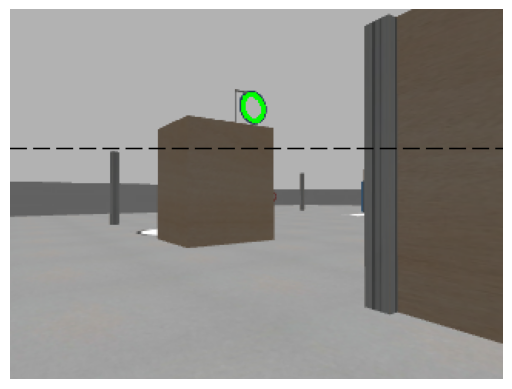

In [108]:
draw_ellipses2(ring_blue, ellipses_per_image_color[3][1:2])

In [109]:
ellipse1_red = ellipses_per_image_color[1][5]
ellipse2_red = ellipses_per_image_color[1][6]
ring_re = Ring(ellipse1_red, ellipse2_red)

ellipse1_green = ellipses_per_image_color[2][0]
ellipse2_green = ellipses_per_image_color[2][1]
ring_gr = Ring(ellipse1_green, ellipse2_green)

ellipse1_black = ellipses_per_image_color[0][3]
ellipse2_black = ellipses_per_image_color[0][4]
ring_bl = Ring(ellipse1_black, ellipse2_black)

ellipse1_blue = ellipses_per_image_color[3][0]
ellipse2_blue = ellipses_per_image_color[3][1]
ring_blu = Ring(ellipse1_blue, ellipse2_blue)

In [ ]:
height, width = ring_red.shape[:2]
yy, xx = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

In [55]:
def ellipse_mask(xx, yy, center, axes, angle_deg):
    a = axes[0] / 2
    b = axes[1] / 2
    x_prime = xx - center[0]
    y_prime = yy - center[1]
    angle_rad = np.radians(angle_deg)
    cos = np.cos(angle_rad)
    sin = np.sin(angle_rad)
    ellipse_eq = ((cos * x_prime + sin * y_prime) ** 2) / (a ** 2) + \
                 ((sin * x_prime - cos * y_prime) ** 2) / (b ** 2)
    return ellipse_eq < 1

In [88]:
ring = ring_re
outer_mask = ellipse_mask(xx, yy, (ring.center1.x, ring.center1.y), ring.ellipse1[1], ring.ellipse1[2])
inner_mask = ellipse_mask(xx, yy, (ring.center2.x, ring.center2.y), ring.ellipse2[1], ring.ellipse2[2])
ring_mask = outer_mask & (~inner_mask)

# Check if the depth points are valid
# valid_depth = np.isfinite(depth_points[..., 0])  # or check all 3 coords
# final_mask = ring_mask & valid_depth

In [89]:
# ring_coords = depth_points[final_mask]
ring_colors = ring_red[ring_mask]  # BGR format

In [90]:
hsv_colors = cv2.cvtColor(ring_colors.reshape(-1, 1, 3).astype(np.uint8), cv2.COLOR_BGR2HSV).reshape(-1, 3)
hue = hsv_colors[:, 0]
saturation = hsv_colors[:, 1]

avg_hue = np.mean(hue)
avg_saturation = np.mean(saturation)

print(f"Average hue is {avg_hue}, average saturation is {avg_saturation}")

if avg_saturation < 30:
    print("Color is likely black")

if avg_hue < 30 or avg_hue > 315:
    print("Color is likely red")
elif 30 <= avg_hue < 80:
    print("Color is likely yellow")
elif 80 <= avg_hue < 170:
    print("Color is likely green")
elif 170 <= avg_hue < 260:
    print("Color is likely blue")

Average hue is 2.8068181818181817, average saturation is 146.51136363636363
Color is likely red


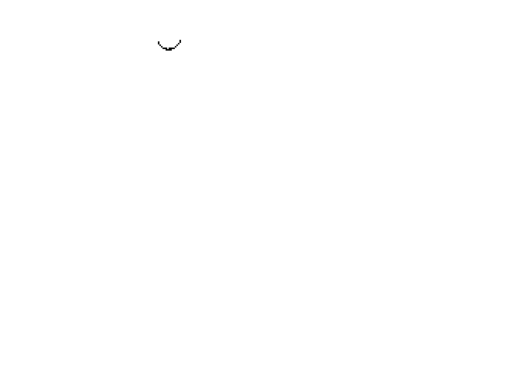

In [84]:
# Display the mask
ring_black_rgb = cv2.cvtColor(ring_black, cv2.COLOR_BGR2RGB)
masked_image = ring_black_rgb.copy()
masked_image[~ring_mask] = 255  # Set non-ring pixels to black

plt.imshow(masked_image)
plt.axis('off')
plt.show()